<a href="https://colab.research.google.com/github/satuelisa/NLPF/blob/main/NLPF_08_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages("tidytext") # once per computer

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘SnowballC’, ‘hunspell’, ‘janeaustenr’, ‘tokenizers’




In [3]:
library(tidyverse)
library(tidytext)
library(SnowballC)

Let's get a book as example data again.

In [4]:
install.packages("gutenbergr") # removed from CRAN in October 2022

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘gutenbergr’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”


In [ ]:
library(gutenbergr)
mirror <- "http://mirrors.xmission.com/gutenberg/"
raw <- gutenberg_download(1998, mirror = mirror) # this one is Nietsche's Thus Spake Zarathustra

We already know how to get a tf-idf matrix, treating the chapters (roughly).

In [ ]:
head(raw)
dim(raw)
introEnds <- which(raw == "Weimar, December 1905.", arr.ind = TRUE)
introEnds
appendixStarts <- which(raw == "APPENDIX.", arr.ind = TRUE)
appendixStarts
content <- raw %>% slice((introEnds[1] + 1):(appendixStarts[1] - 1))

gutenberg_id,text
<int>,<chr>
1998,THUS SPAKE ZARATHUSTRA
1998,
1998,A BOOK FOR ALL AND NONE
1998,
1998,
1998,By Friedrich Nietzsche


[1] 15536     2

row,col
664,2


row,col
13837,2


In [ ]:
head(content)
tail(content)

gutenberg_id,text
<int>,<chr>
1998,
1998,
1998,
1998,
1998,THUS SPAKE ZARATHUSTRA.
1998,


gutenberg_id,text
<int>,<chr>
1998,"Thus spake Zarathustra and left his cave, glowing and strong, like a"
1998,morning sun coming out of gloomy mountains.
1998,
1998,
1998,
1998,


In [ ]:
book <- content %>% mutate(linenumber = row_number(), chapter = cumsum(str_detect(text, regex("^[:digit:].$"))))
table(book$chapter) # 67 chapters of varying lengths
head(book)


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
  17   41   72   96   78  101   46   25   62 2233   91   55 3171   88  418   32 
  16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31 
 116  385   54  283   69  137   31  148   14   64   42   19   19   19   23   33 
  32   33   34   35   36   37   38   39   40   41   42   43   44   45   46   47 
 600   38  358   80   50   55   24   24   24   22   22   23  324  117  194  132 
  48   49   50   51   52   53   54   55   56   57   58   59   60   61   62   63 
1306   24   15   41   13   16   23   11   19  267   19   46  243   55  164   70 
  64   65   66   67   68   69   70   71   72   73   74   75   76 
  76  107   26   26   49   30   25   20   21   23   23   23  222 

gutenberg_id,text,linenumber,chapter
<int>,<chr>,<int>,<int>
1998,,1,0
1998,,2,0
1998,,3,0
1998,,4,0
1998,THUS SPAKE ZARATHUSTRA.,5,0
1998,,6,0


Tokenize.

In [ ]:
tokens <- book %>% unnest_tokens(word, text)
head(tokens)

gutenberg_id,linenumber,chapter,word
<int>,<int>,<int>,<chr>
1998,5,0,thus
1998,5,0,spake
1998,5,0,zarathustra
1998,10,0,first
1998,10,0,part
1998,10,0,zarathustra’s


Remove stop words.

In [ ]:
install.packages("stopwords")
library(stopwords)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘ISOcodes’




In [ ]:
clean <- tokens %>% anti_join(get_stopwords(), by = "word")
head(clean)

gutenberg_id,linenumber,chapter,word
<int>,<int>,<int>,<chr>
1998,5,0,thus
1998,5,0,spake
1998,5,0,zarathustra
1998,10,0,first
1998,10,0,part
1998,10,0,zarathustra’s


Stem, now that we know how to do it (and that it is sometimes helpful), in a new column.

In [ ]:
stemmed <- clean %>% mutate(stem = wordStem(word))
head(stemmed)

gutenberg_id,linenumber,chapter,word,stem
<int>,<int>,<int>,<chr>,<chr>
1998,5,0,thus,thu
1998,5,0,spake,spake
1998,5,0,zarathustra,zarathustra
1998,10,0,first,first
1998,10,0,part,part
1998,10,0,zarathustra’s,zarathustra’


Count the term frequencies.

In [ ]:
counted <- stemmed %>% count(chapter, stem) 
head(counted)
dim(counted)

chapter,stem,n
<int>,<chr>,<int>
0,discours,1
0,first,1
0,part,1
0,prologu,1
0,spake,1
0,thu,1


[1] 19242     3

We could ditch the low-frequency ones to make it a bit smaller and easier to visualize.

In [ ]:
table(counted$chapter)


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
   8  110  152  179  133  214  167   82  195 1976  202  156 2576  231  672   92 
  16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31 
 249  667  150  533  179  326   92  307   37  169  105   55   46   45   59   71 
  32   33   34   35   36   37   38   39   40   41   42   43   44   45   46   47 
 841  115  570  227  113   49   62   65   54   51   51   52  596  291  397  232 
  48   49   50   51   52   53   54   55   56   57   58   59   60   61   62   63 
1568   46   44   87   31   49   61   31   49  451   55  109  471  166  272  195 
  64   65   66   67   68   69   70   71   72   73   74   75   76 
 186  219   66   55  152  109   60   64   60   64   56   61  404 

In [ ]:
recurrent <- counted %>% filter(n > 1) # keep any stem that repeats 
dim(recurrent)
table(recurrent$chapter)
head(recurrent)

[1] 7215    3


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
   1   24   52   75   46   65   44   13   61  946   63   43 1340   72  280   18 
  16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31 
  77  245   39  196   46   80   13   89    8   35   24   10    8   10   12   26 
  32   33   34   35   36   37   38   39   40   41   42   43   44   45   46   47 
 334   25  235   44   35    7   19   16   15   14    8   11  251   93  133   68 
  48   49   50   51   52   53   54   55   56   57   58   59   60   61   62   63 
 703   18    9   33    8   10   12    6    6  165   17   36  149   44   91   47 
  64   65   66   67   68   69   70   71   72   73   74   75   76 
  46   83   15   10   39   23   21   13   20   22   17   21  162 

chapter,stem,n
<int>,<chr>,<int>
0,zarathustra’,2
1,bless,3
1,cup,2
1,descend,2
1,even,2
1,go,4


Build a document-term frequency matrix.

In [ ]:
install.packages("tm")
library(tm)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘NLP’, ‘slam’, ‘BH’


Loading required package: NLP


Attaching package: ‘NLP’


The following object is masked from ‘package:ggplot2’:

    annotate



Attaching package: ‘tm’


The following object is masked from ‘package:stopwords’:

    stopwords




In [ ]:
tfm <- recurrent %>% cast_dtm(chapter, stem, n)
dim(tfm)

[1]   77 2364

So, this is a very basic vectorization of the stemmed tokens in the document space. We could now compute their similarity using the *cosine similarity* of the now-numerical vectors.

In [ ]:
install.packages("qlcMatrix")
library(qlcMatrix)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘sparsesvd’, ‘docopt’


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loading required package: slam

Loading required package: sparsesvd


Attaching package: ‘qlcMatrix’


The following object is masked from ‘package:purrr’:

    none




In [ ]:
m <-  Matrix::sparseMatrix(i = tfm$i, j = tfm$j, x = tfm$v, dims = c(tfm$nrow, tfm$ncol), dimnames = tfm$dimnames)

In [ ]:
sim <- cosSparse(m) # https://rdrr.io/cran/qlcMatrix/man/cosSparse.html

It would be cool to see that, but let's not forget that this is a *large* sparse matrix. We could plot a smaller one, just to see.


In [ ]:
smaller <- recurrent %>% filter(n > 25) %>% cast_dtm(chapter, stem, n)
dim(smaller)
sm <-  Matrix::sparseMatrix(i = smaller$i, j = smaller$j, x = smaller$v, dims = c(smaller$nrow, smaller$ncol), dimnames = smaller$dimnames)
ss <- cosSparse(sm)

[1] 14 79

In [ ]:
install.packages("plot.matrix")
library(plot.matrix)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



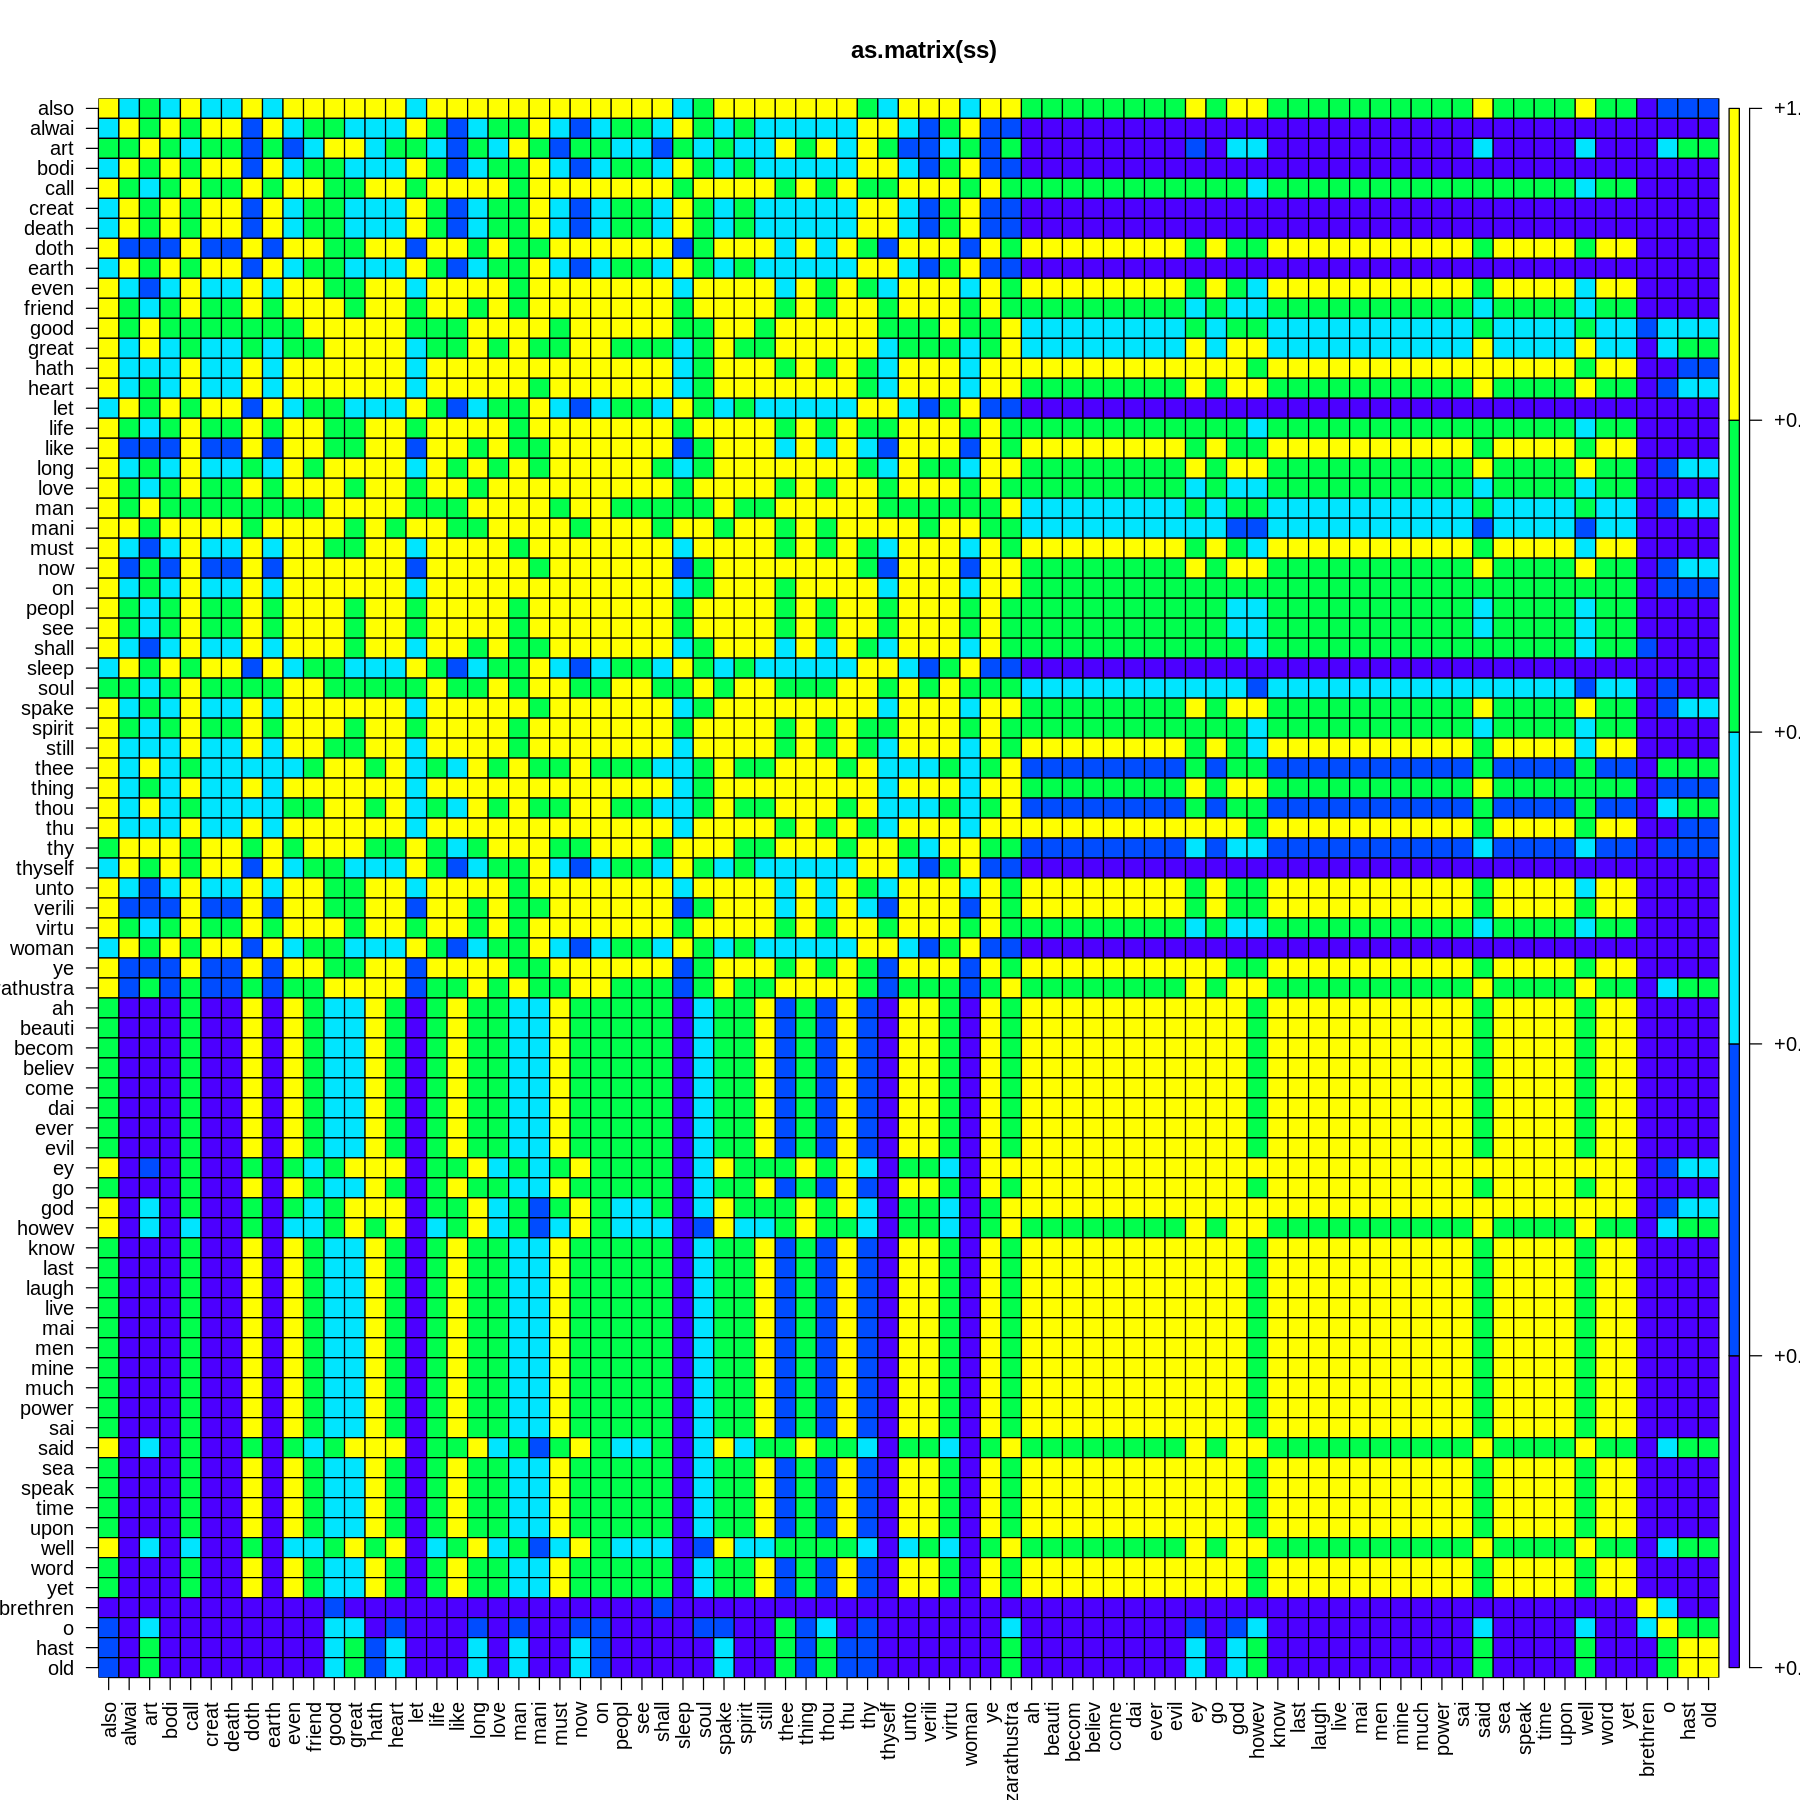

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 15)
par(las = 2)
# https://cran.r-project.org/web/packages/plot.matrix/vignettes/plot.matrix.html
plot(as.matrix(ss), col = topo.colors, xlab="", ylab="") # make into full matrix for drawing

We could also of course compute the tf-idf weights to get a better matrix in terms of the estimated relative importance of the words.

In [ ]:
weighted <- counted %>% bind_tf_idf(stem, chapter, n)
head(weighted)
table(weighted$chapter)

chapter,stem,n,tf,idf,tf_idf
<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
0,discours,1,0.1111111,2.1465808,0.23850898
0,first,1,0.1111111,1.1657516,0.12952795
0,part,1,0.1111111,2.2643639,0.25159599
0,prologu,1,0.1111111,3.6506582,0.40562869
0,spake,1,0.1111111,0.8472979,0.09414421
0,thu,1,0.1111111,0.4726044,0.05251160



   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
   8  110  152  179  133  214  167   82  195 1976  202  156 2576  231  672   92 
  16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31 
 249  667  150  533  179  326   92  307   37  169  105   55   46   45   59   71 
  32   33   34   35   36   37   38   39   40   41   42   43   44   45   46   47 
 841  115  570  227  113   49   62   65   54   51   51   52  596  291  397  232 
  48   49   50   51   52   53   54   55   56   57   58   59   60   61   62   63 
1568   46   44   87   31   49   61   31   49  451   55  109  471  166  272  195 
  64   65   66   67   68   69   70   71   72   73   74   75   76 
 186  219   66   55  152  109   60   64   60   64   56   61  404 

Build the matrix.

In [ ]:
install.packages("quanteda")
library(quanteda)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘fastmatch’, ‘RcppParallel’, ‘RcppArmadillo’


Package version: 3.2.1
Unicode version: 10.0
ICU version: 60.2

Parallel computing: 2 of 2 threads used.

See https://quanteda.io for tutorials and examples.


Attaching package: ‘quanteda’


The following object is masked from ‘package:tm’:

    stopwords


The following objects are masked from ‘package:NLP’:

    meta, meta<-




So, now this is sort of a vectorization of each token since we can represent it numerically in terms of its tf-idf across the corpos. So we could redo the similarity matrix in these terms. Let's filter again to get rid of the very low weights so we can visualize results.

In [ ]:
bigger <- weighted %>% filter(tf_idf > 0.075)
dim(bigger)

[1] 98  6

In [ ]:
tfidf <- bigger %>% cast_dfm(chapter, stem, tf_idf)
dim(tfidf)
max(tfidf)

[1] 35 94

[1] 0.4056287

In [ ]:
install.packages("proxy") # https://cran.r-project.org/web/packages/proxy/proxy.pdf
require(proxy) # for a dist that includes cosine similarity

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: proxy


Attaching package: ‘proxy’


The following object is masked from ‘package:Matrix’:

    as.matrix


The following objects are masked from ‘package:stats’:

    as.dist, dist


The following object is masked from ‘package:base’:

    as.matrix




In [ ]:
aux <- as.matrix(tfidf)
dim(aux)
st <- simil(t(aux), method = "cosine") # if we do not transpose, we get a document-document similarity, which is also kind of cool

[1] 35 94

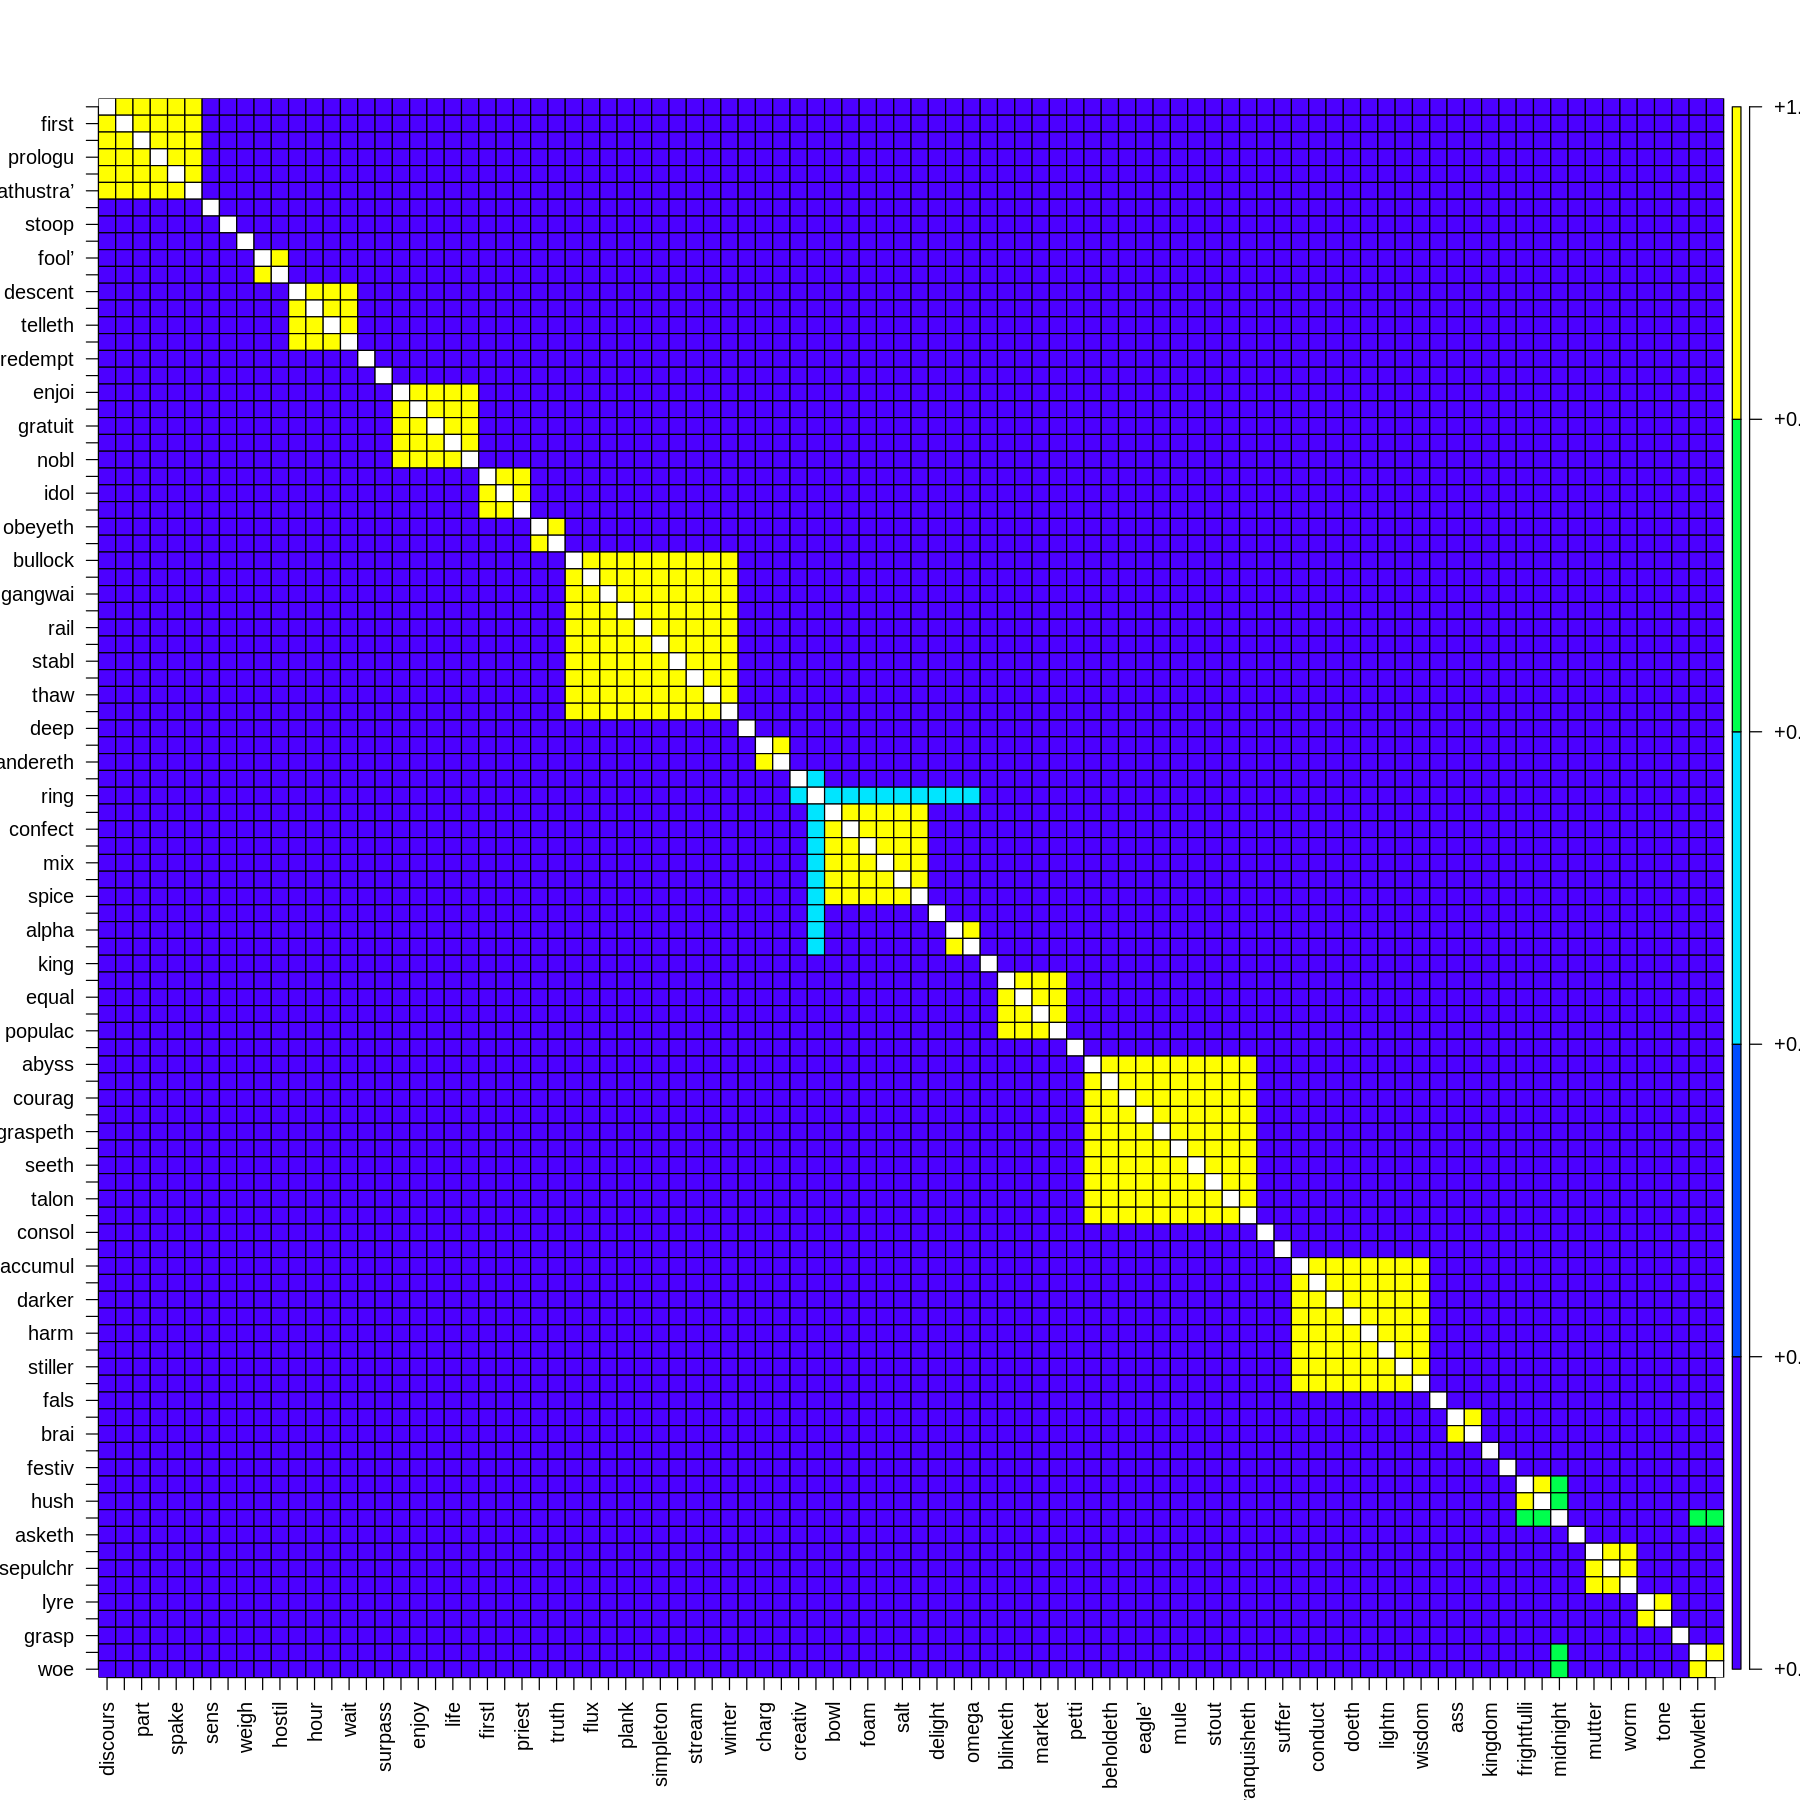

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 15)
par(las = 2)
plot(as.matrix(st), col = topo.colors, xlab="", ylab="", main="") 

That turned out to be a bit of binary "yes"/"no" situation.

Another option is to use the PMI which is a probabilistic way of saying whether two words appear to have a relation in terms of do they appear one after another with a higher frequency than they would if the words were ordered at random. 

This implies estimating the probability of occurence of each individual word and also the probability of each bigram. Then, take the paired one, divide it by the product of the individual probabilities, and shove that into a base-two logarithm to compute the PMI. 

Deepanshu Bhalla has [a great tutorial](https://www.listendata.com/2022/06/pointwise-mutual-information-pmi.html#id-df9b7d) that explains how to compute PMI given a document-term frequency matrix like the one we already have.

In [ ]:
lines <- content$text
k <- length(lines)
full <- "" # making a massive string
for (i in 1:k) {
  # cleaning out the punctuation
  line = gsub('[[:punct:] ]+', ' ', lines[i])   
  if (length(line) > 0) {
    # all lower case
    full <- paste(full, tolower(line), sep = " ")
  }
}
nchar(full)

[1] 497892

In [ ]:
# computing the bigram frequencies
words <- tokens(full) 
stems <- tokens_wordstem(words)
bigrams <- fcm(stems, context = "window", window = 1L, ordered = T)

What does that look like?

In [ ]:
head(bigrams)

Feature co-occurrence matrix of: 6 by 5,456 features.
             features
features      thus spake zarathustra first part  s discours prologu 1 when
  thus           0   112           1     0    0  0        1       0 0    1
  spake         17     0          80     0    0  0        0       0 0    2
  zarathustra    5     5           2     1    0 31        0       0 0    3
  first          0     0           0     0    1  0        1       0 0    0
  part           1     0           1     0    0  0        0       0 0    0
  s              0     0           0     0    0  0        2       1 0    0
[ reached max_nfeat ... 5,446 more features ]

We need that number of words into a variable since we have to compute the PMI of each one. We might not want to really count all possible pairs, though.

In [ ]:
co <- ndoc(bigrams)
co # how many words
co**2 # how many potential word pairs does that make

[1] 5456

[1] 29767936

We also need the individual frequencies.

In [ ]:
counts <- dfm(stems)
counts
total <- sum(counts)
match <- dfm_select(counts, "thus")
as.numeric(match)
length(match)
total

Document-feature matrix of: 1 document, 5,456 features (0.00% sparse) and 0 docvars.
       features
docs    thus spake zarathustra first part   s discours prologu  1 when
  text1  396   168         595    63   13 209       13       2 19  360
[ reached max_nfeat ... 5,446 more features ]

[1] 396

[1] 1

[1] 92402

Time to compute the PMI.



In [ ]:
# based on https://www.listendata.com/2022/06/pointwise-mutual-information-pmi.html#id-099914
PMI <- data.frame(word1 = character(), word2 = character(), ppmi = double()) # put the results in a dataframe
threshold <- 0.01 # ignore anything smaller 
howmany <- 100 # just compute a few, not millions of them
for (i in 1:co) { # each co-occuring word
  for (j in 1:co) { # against each other co-occuring word
   fragment <- convert(bigrams[i, j], to = "data.frame") # easier access albeit a bit slow
   coinfo <- fragment[2]
   cocount <- as.numeric(coinfo)
   if (is.numeric(cocount) && cocount > 0) { # only calculate if nonzero co-occurence
      jp <- cocount / total # joint probability
      if (jp > 0) {
        n1 <- fragment[1] # what was the first token
        n2 <- names(fragment)[2] # what was the second token
        w1 <- as.character(n1) # the first word itself
        w2 <- as.character(n2) # the second word itself
        f1 <- dfm_select(counts, w1) # the freq of the first token
        if (length(f1) == 1) {
          f2 <- dfm_select(counts, w2) # the freq of the second token
          if (length(f2) == 1) { # require nonzero
            p1 <- as.numeric(f1) / total # relative frequency of first token individually
            p2 <- as.numeric(f2) / total # relative frequency of second token individually 
            value <- max(0, log(jp / (p1 * p2) , 2)) # if negative, set it as zero (this is PPMI, positive PMI)
            if (value > threshold) { # interesting enough
              PMI <- rbind(PMI, data.frame(word1 = w1, word2 = w2, ppmi = value))
              if (nrow(PMI) > howmany) {
                break
              }
            }
          }
        }
      }
    }
    if (nrow(PMI) > howmany) {
      break
    }
  }
  if (nrow(PMI) > howmany) {
    break
  }
}

We can visualize this, too, of course, as a weighted graph. Just remember that we did not compute all of them (in order to save time).

In [ ]:
install.packages("igraph") # installed in S4
install.packages("ggraph") # installed in S4
library(igraph) # load always
library(ggraph) # load

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘tweenr’, ‘polyclip’, ‘RcppEigen’, ‘gridExtra’, ‘ggforce’, ‘ggrepel’, ‘viridis’, ‘tidygraph’, ‘graphlayouts’



Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package:tibble’:

    as_data_frame


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




In [ ]:
head(PMI)

,word1,word2,ppmi
,<chr>,<chr>,<dbl>
1,thus,spake,7.281317
2,thus,discours,4.165840
3,thus,did,4.265887
4,thus,unto,2.440015
5,thus,would,1.757755
6,thus,if,0.327121


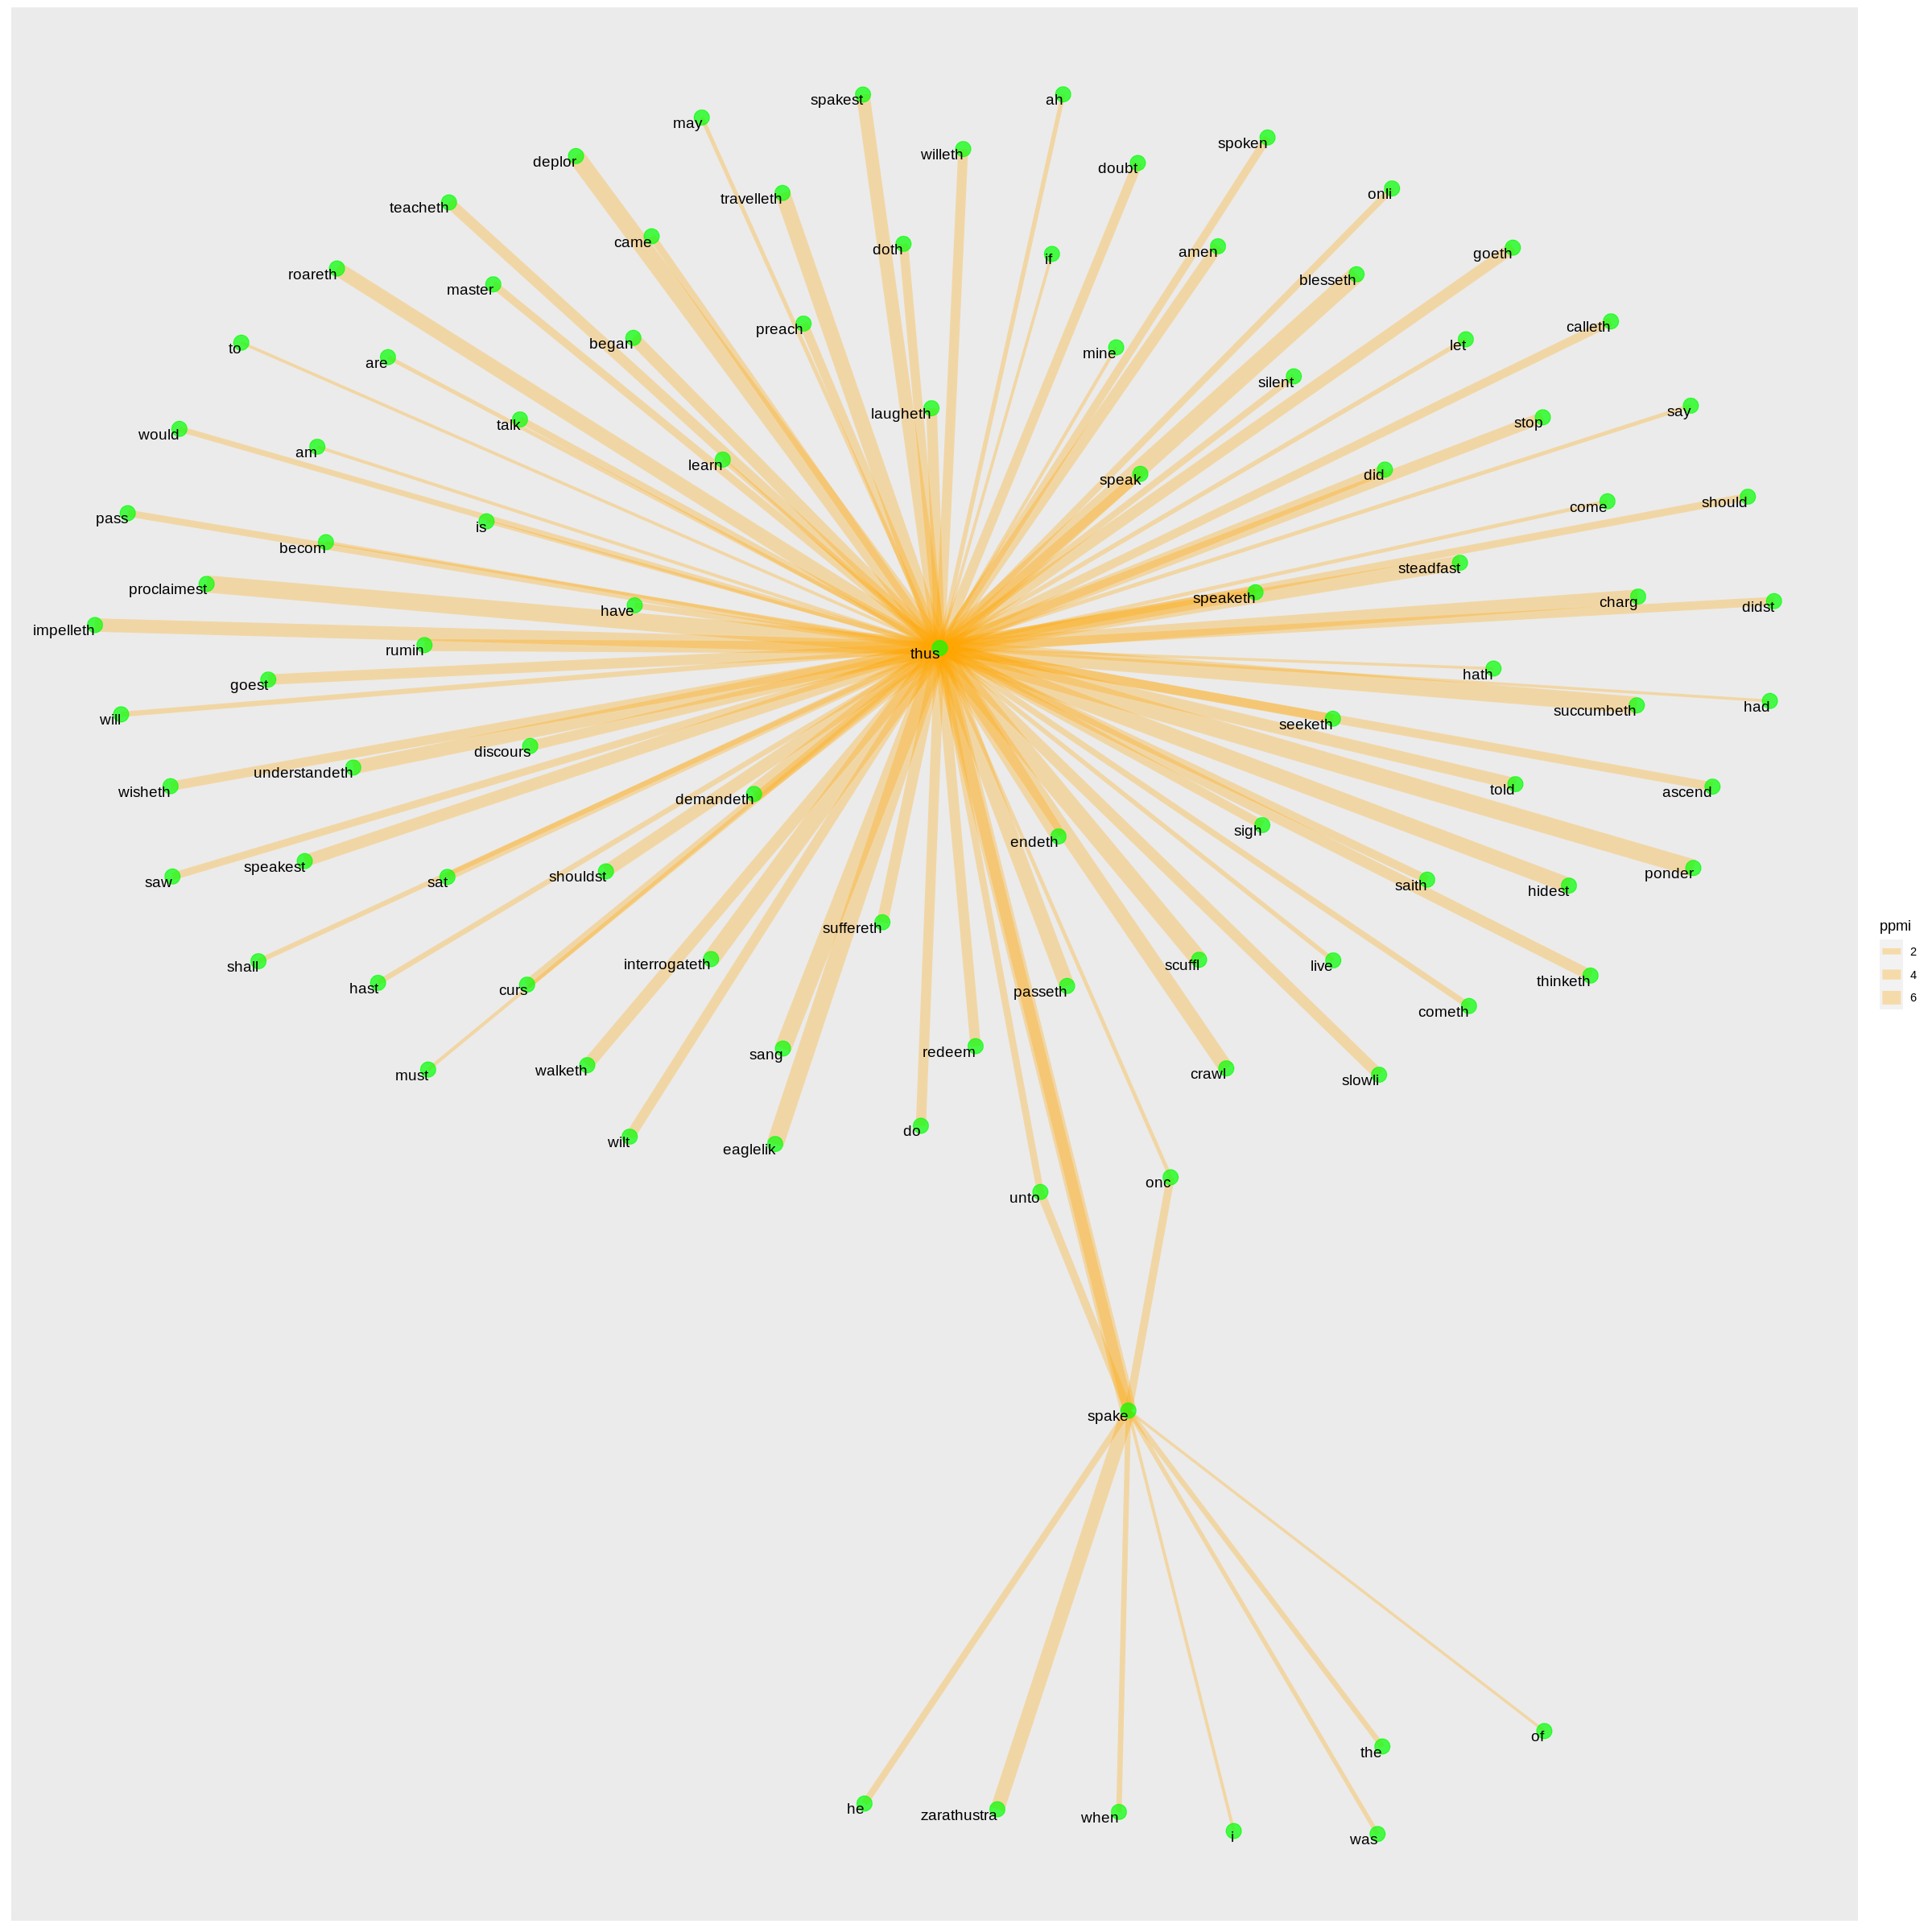

In [ ]:
g <- graph_from_data_frame(PMI)
library(repr)
options(repr.plot.width = 20, repr.plot.height = 20) 
ggraph(g, layout = "fr") + # spring-force
  geom_edge_link(alpha = 0.3, aes(width = ppmi), color = "orange") + # edges
  geom_node_point(alpha = 0.7, color = "green", size = 5) +  # vertices
  geom_node_text(aes(label = name), vjust = 1, hjust = 1, size = 4) # labels

The way in which transformer models tend to represent text is with *word embeddings* like `word2vec`. Of course there is an R package for that.

In [ ]:
install.packages("word2vec") # https://cran.r-project.org/web/packages/word2vec/word2vec.pdf
library(word2vec)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘RcppProgress’




The beauty of these is that we can work in a lower-dimensional space whereas the `tf-idf` vectors to represent documents are as long as the number of terms in the corpus and those for the  terms are as long as the number of documents in the corpus. The computations behind this idea are based on "sliding windows" of consequtive words within text.

In [ ]:
head(content$text, 10) # the lines of the book can be input here
target <- 30 # what dimensionality are we willing to deal with
model <- word2vec(x = content$text, type = "skip-gram", dim = target, stopwords = stopwords()) 

[1] ""                                     
 [2] ""                                     
 [3] ""                                     
 [4] ""                                     
 [5] "THUS SPAKE ZARATHUSTRA."              
 [6] ""                                     
 [7] ""                                     
 [8] ""                                     
 [9] ""                                     
[10] "FIRST PART. ZARATHUSTRA’S DISCOURSES."

We can use the model built to gain access to the calculated embeddings. Note that we could again use cosine similarity between these vectors as well.

In [ ]:
emb <- as.matrix(model)
dim(emb)
emb[c("thus"), ] # getting the row of corresponding to a specific word

[1] 1792   30

[1] -1.34039223  1.13157964  0.52378273  1.27703798  0.27427933  0.83350849
 [7]  0.25549033 -2.49831796 -0.94192570 -0.32953280 -0.23941259  2.22319913
[13]  0.03982503 -0.59877217 -0.77135497  0.15725662  0.09531753 -0.53640825
[19]  0.64678574 -1.71244967  0.37017301  1.59974384  0.54813933  0.76805216
[25]  1.16034937 -0.47356564  0.68040717 -0.34022751 -0.33186293 -1.21307969

Let's make a three-dimensional mapping so we can [draw](http://www.sthda.com/english/wiki/impressive-package-for-3d-and-4d-graph-r-software-and-data-visualization) it. 

In [ ]:
m3d <- word2vec(x = content$text, type = "skip-gram", dim = 3, stopwords = stopwords()) 
e3d <- as.matrix(m3d)

In [ ]:
install.packages("plot3D")
library(plot3D)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘misc3d’


Warning message:
“no DISPLAY variable so Tk is not available”


descend,0.7760597,-1.429044,-0.5962926
violence,0.7986538,-1.400270,-0.6335591
Lift,0.7583095,-1.448566,-0.5715082
spoil,0.7899376,-1.400744,-0.6433614
“Give,0.8008829,-1.403720,-0.6230226
wolves,0.7802732,-1.420997,-0.6098701


descend  violence      Lift     spoil     “Give    wolves 
0.7760597 0.7986538 0.7583095 0.7899376 0.8008829 0.7802732

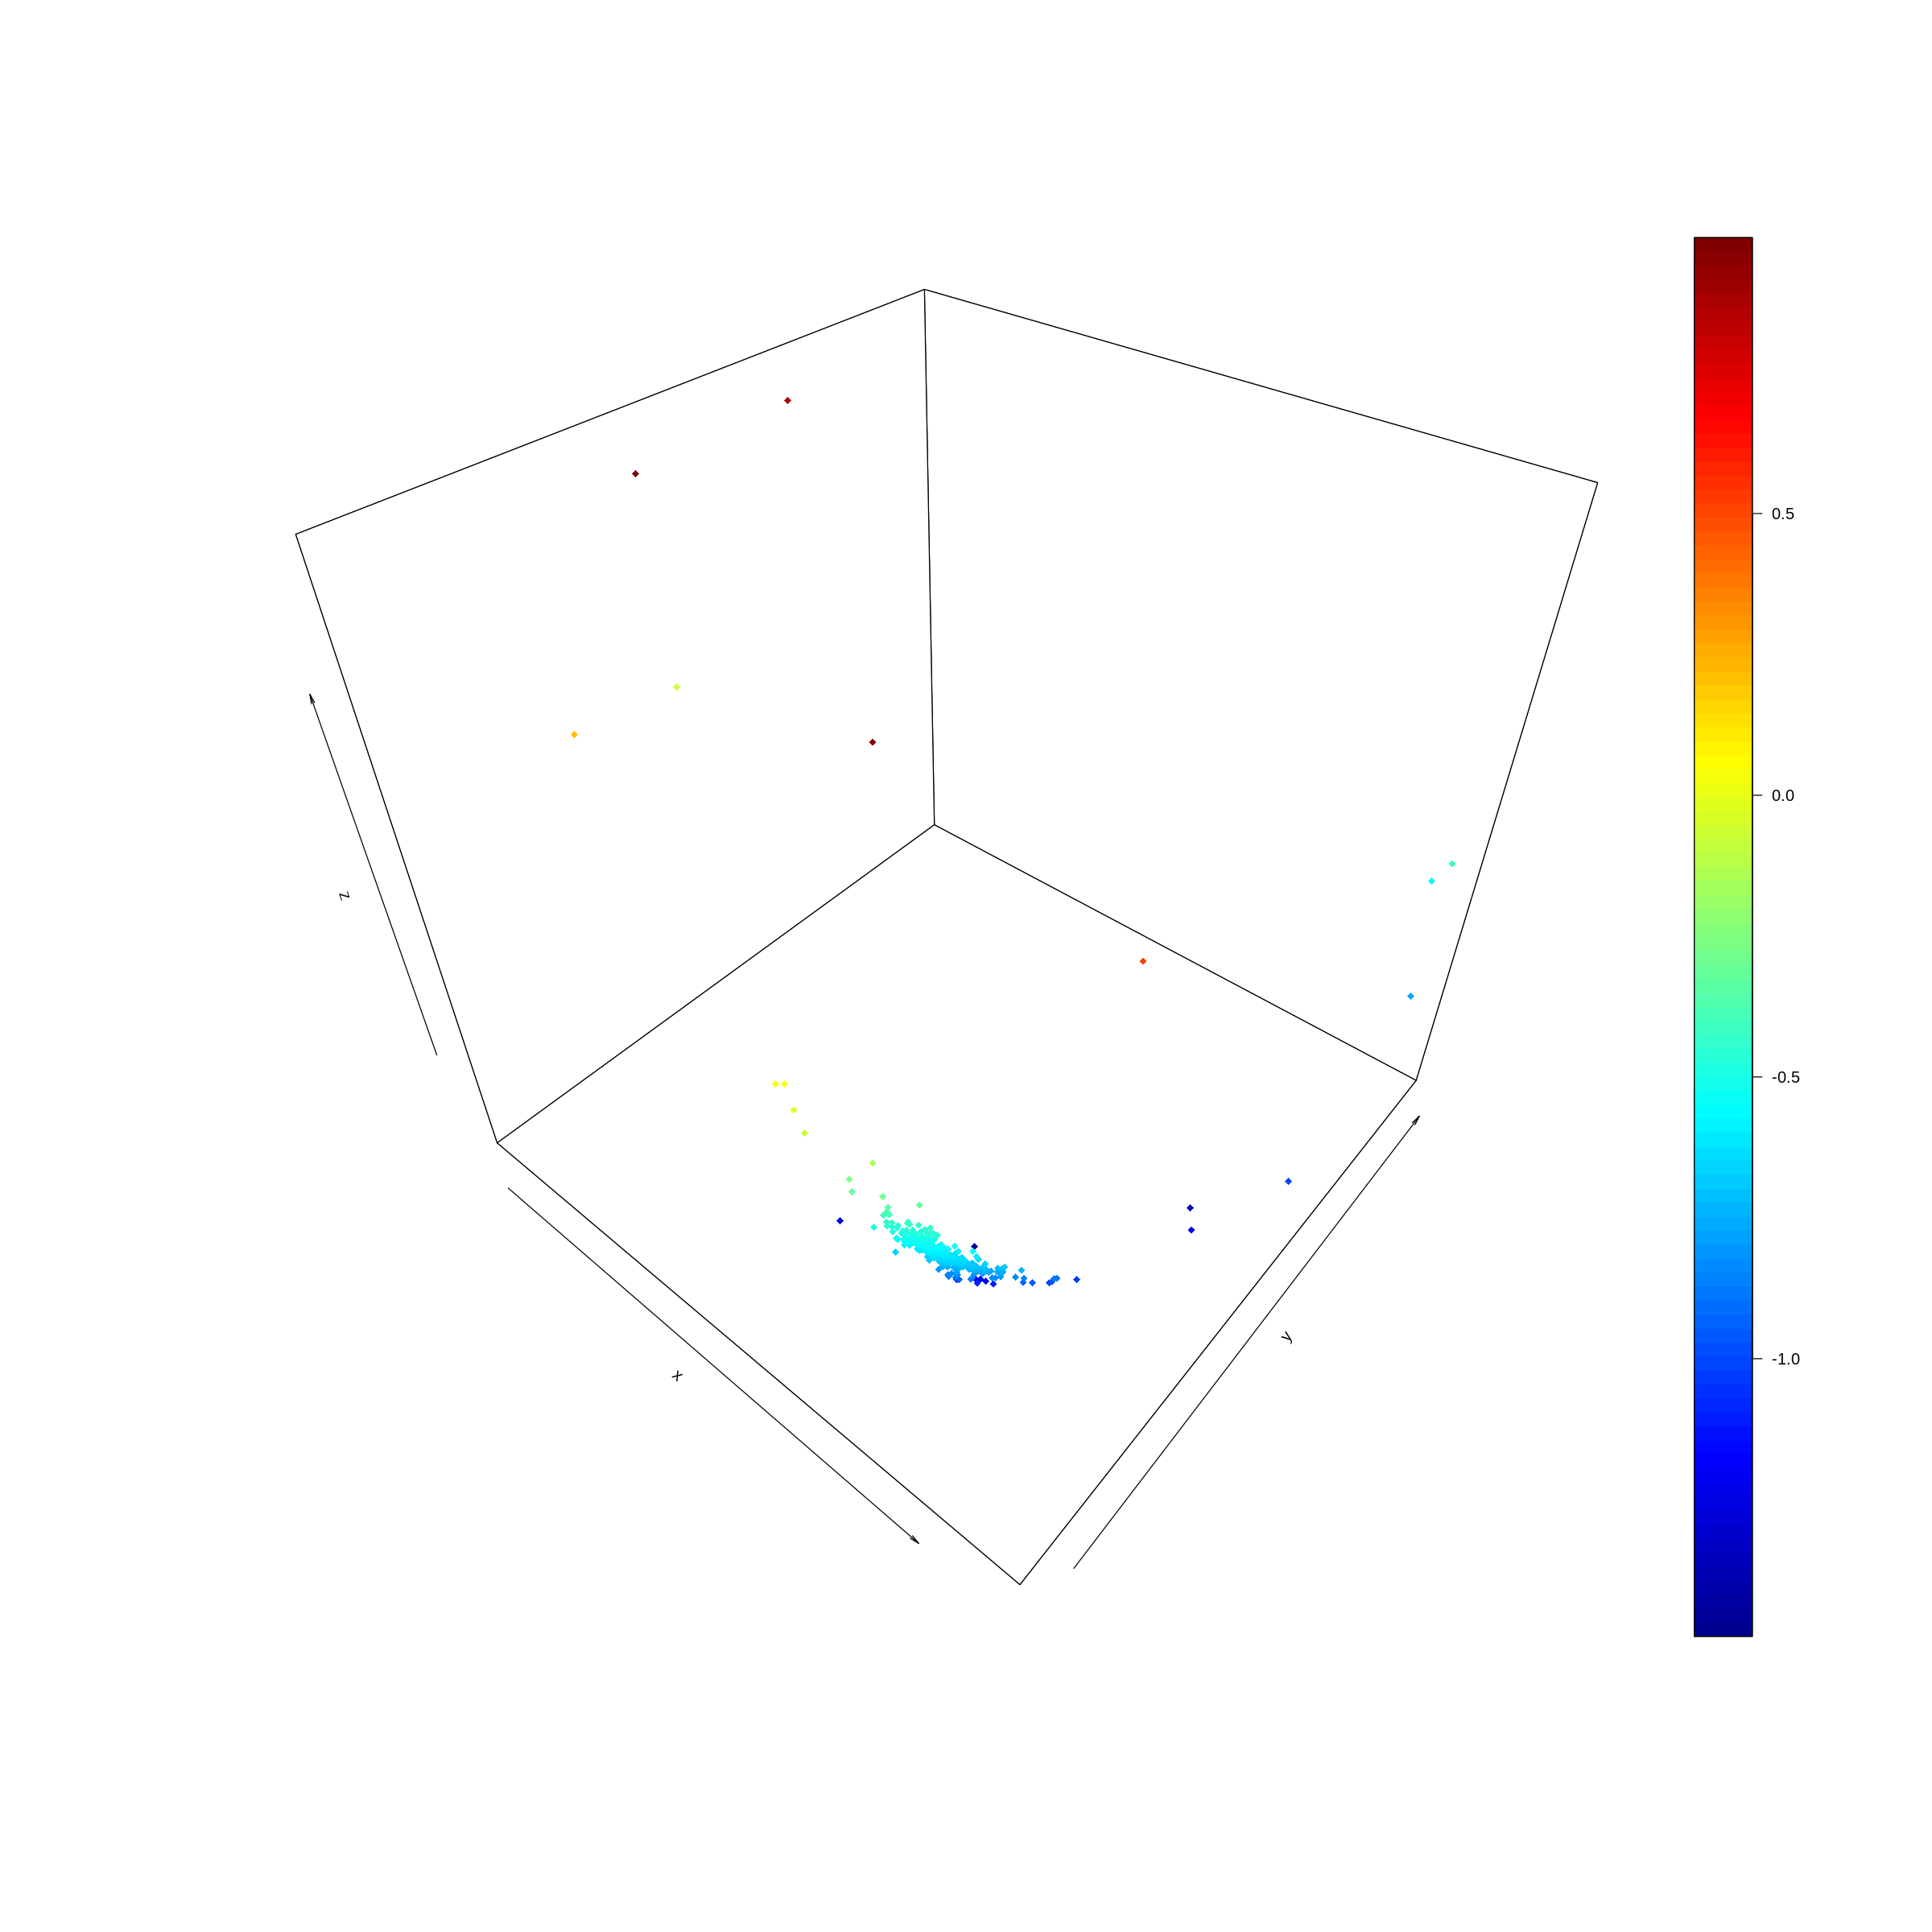

In [ ]:
head(e3d)
head(e3d[, 1])
scatter3D(e3d[, 1], e3d[, 2], e3d[, 3], pch = 18)

Nice, but what words are those? Especially the ones grouped down on the xy-plane.

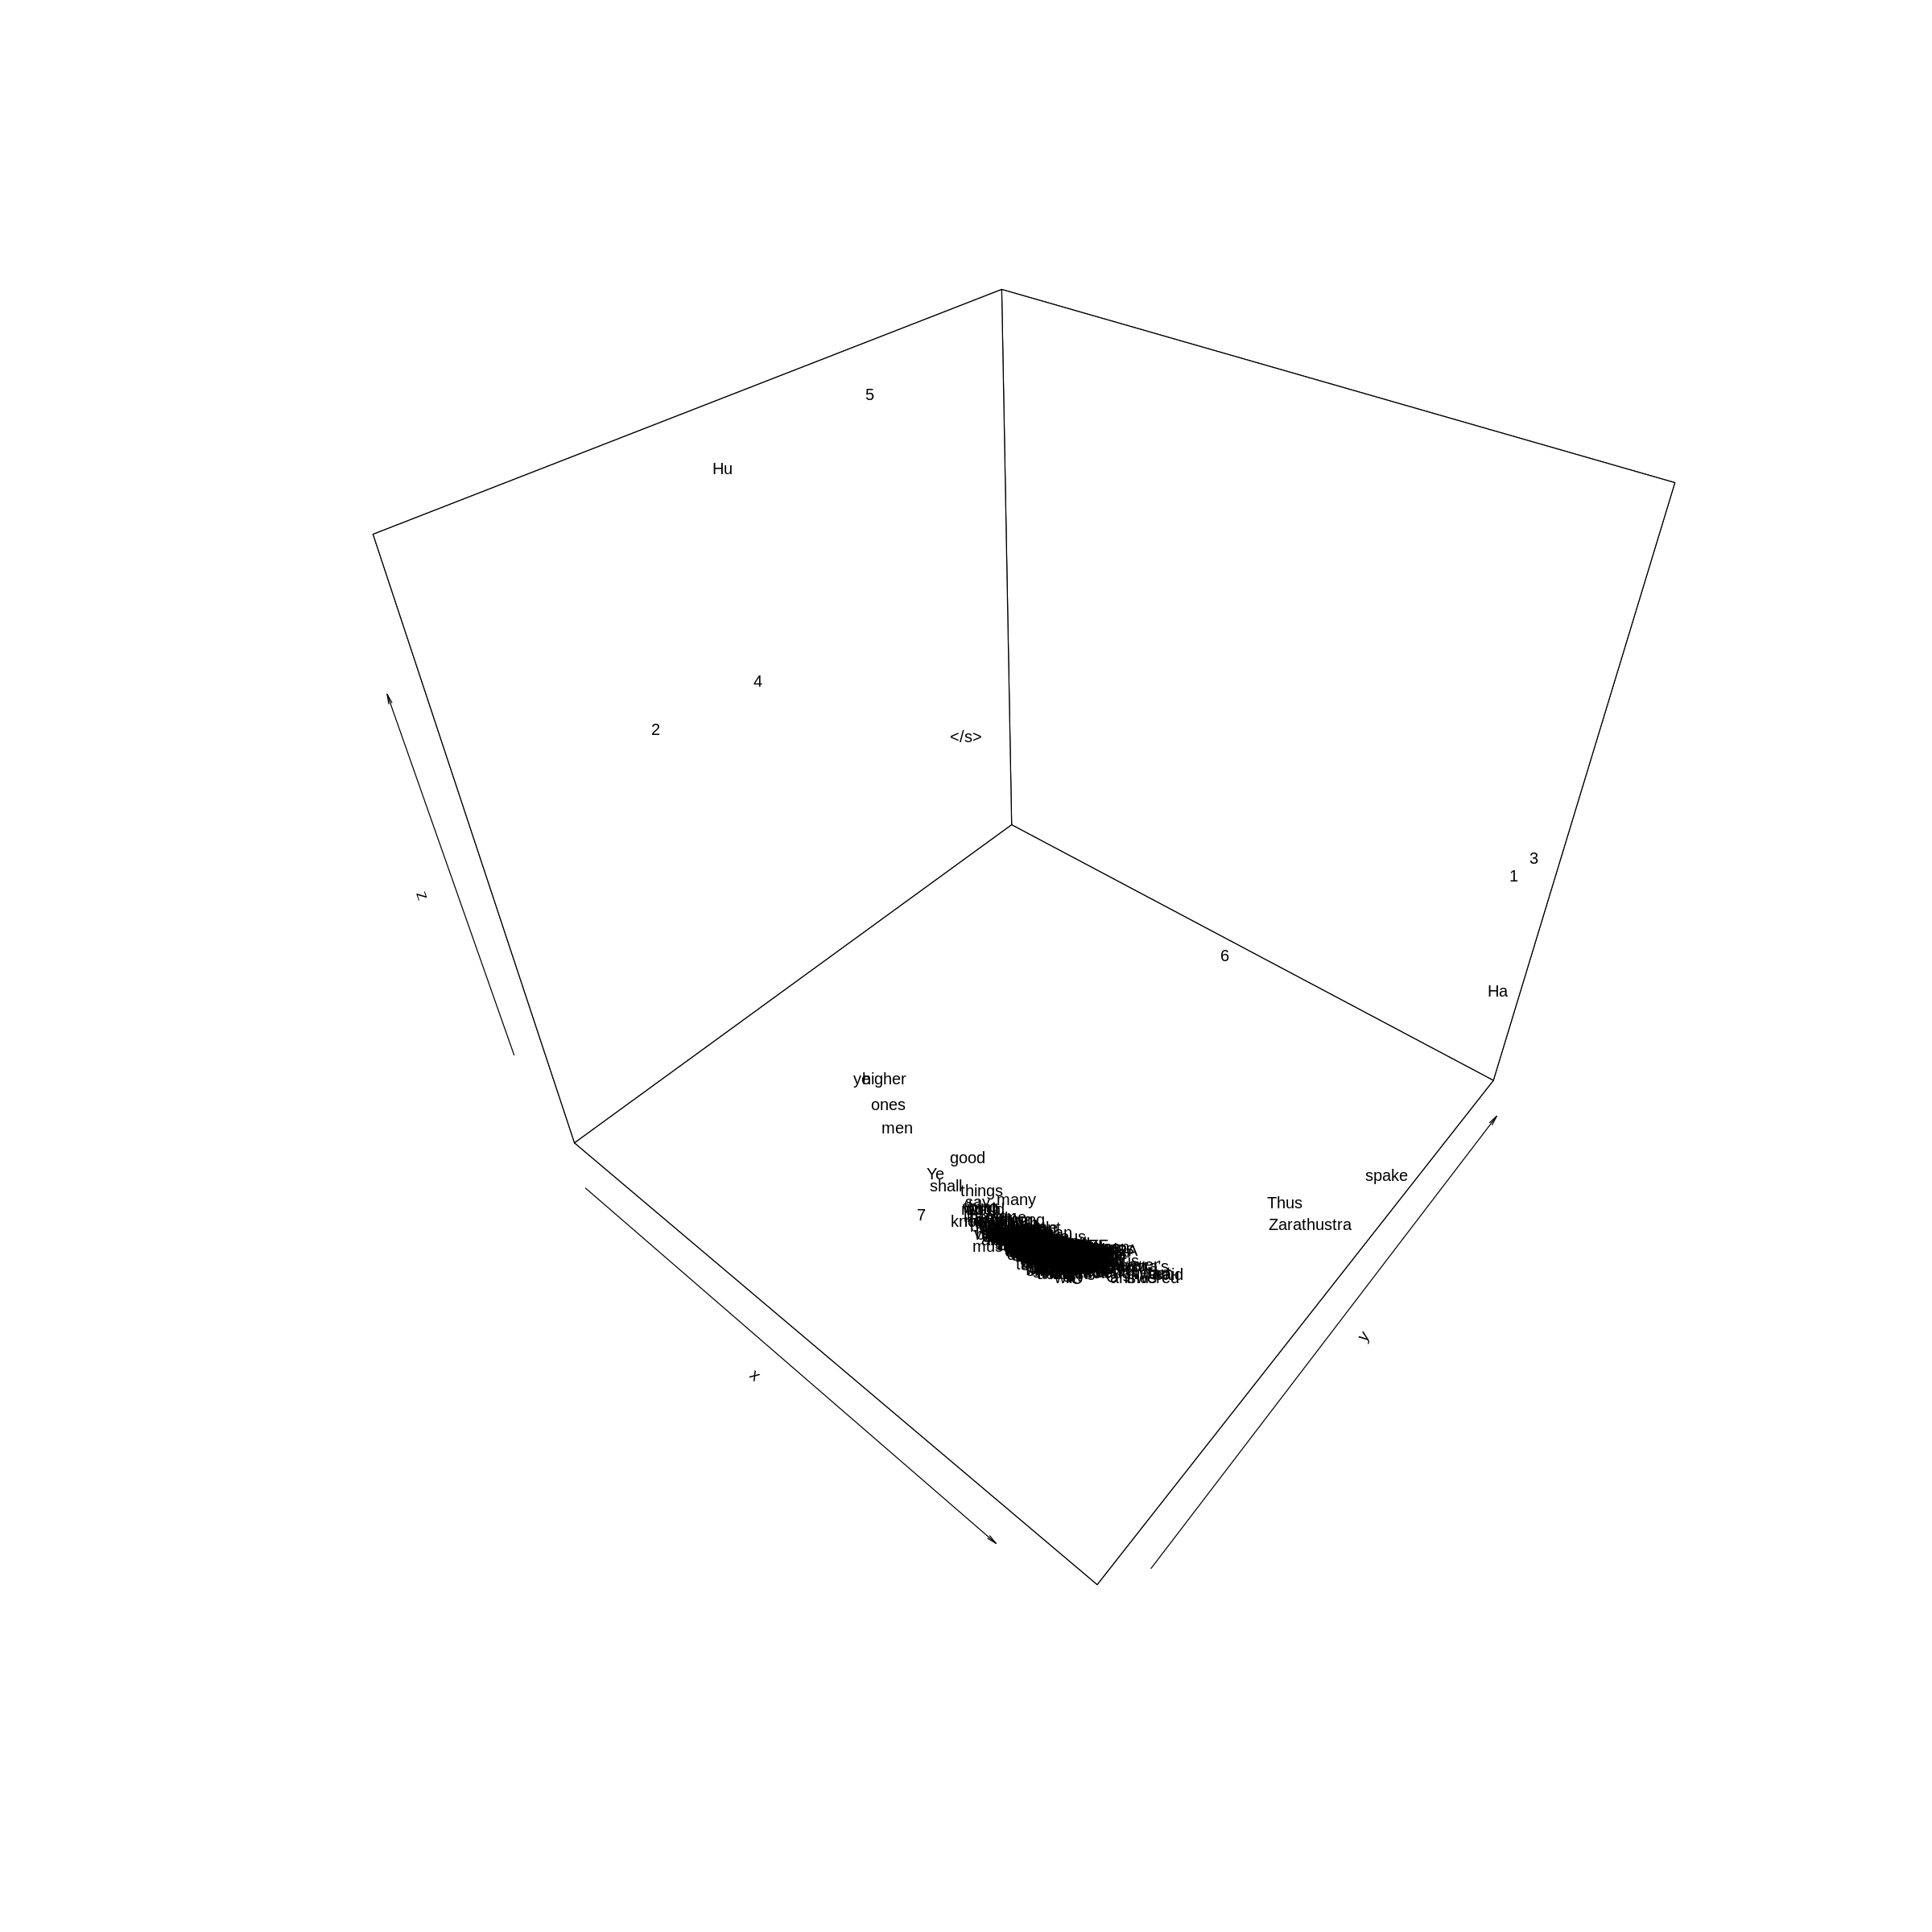

In [ ]:
text3D(e3d[, 1], e3d[, 2], e3d[, 3], labels = rownames(e3d))

Heh, we had not removed digits from `content` so those are evidently different from other words. There is also something that looks like an HTML tag there. Note that we can now cluster the words in the vector space we have built.

In [ ]:
library(stats)
clusters <- kmeans(e3d, centers = 10, iter.max = 30, algorithm = "Hartigan-Wong")

What do we have here?

In [ ]:
summary(clusters)
head(clusters)

             Length Class  Mode   
cluster      1792   -none- numeric
centers        30   -none- numeric
totss           1   -none- numeric
withinss       10   -none- numeric
tot.withinss    1   -none- numeric
betweenss       1   -none- numeric
size           10   -none- numeric
iter            1   -none- numeric
ifault          1   -none- numeric

1,-1.4088127,-0.5510874,0.51712980
2,0.5190088,-1.6411795,-0.08740597
3,0.7414124,-1.4836146,-0.49367874
4,1.3272786,0.6804822,-0.68313385
5,0.8764946,-1.2181383,0.74124897
6,0.7971109,-1.4008017,-0.63376227
7,0.8410688,-1.3337699,-0.71313611
8,0.6222962,-0.8684667,-1.27800001
9,0.7845939,-1.4241826,-0.59631717
10,0.8828222,-1.1624183,-0.91814021


Yeah, but what are the clusters *like*?

In [ ]:
install.packages("NbClust") # https://rdrr.io/cran/NbClust/

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
install.packages("factoextra") # https://www.rdocumentation.org/packages/factoextra/versions/1.0.7

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘SparseM’, ‘MatrixModels’, ‘sp’, ‘minqa’, ‘nloptr’, ‘later’, ‘carData’, ‘pbkrtest’, ‘quantreg’, ‘maptools’, ‘lme4’, ‘htmlwidgets’, ‘crosstalk’, ‘promises’, ‘corrplot’, ‘car’, ‘DT’, ‘ellipse’, ‘flashClust’, ‘leaps’, ‘scatterplot3d’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘polynom’, ‘rstatix’, ‘plyr’, ‘abind’, ‘dendextend’, ‘FactoMineR’, ‘ggpubr’, ‘reshape2’




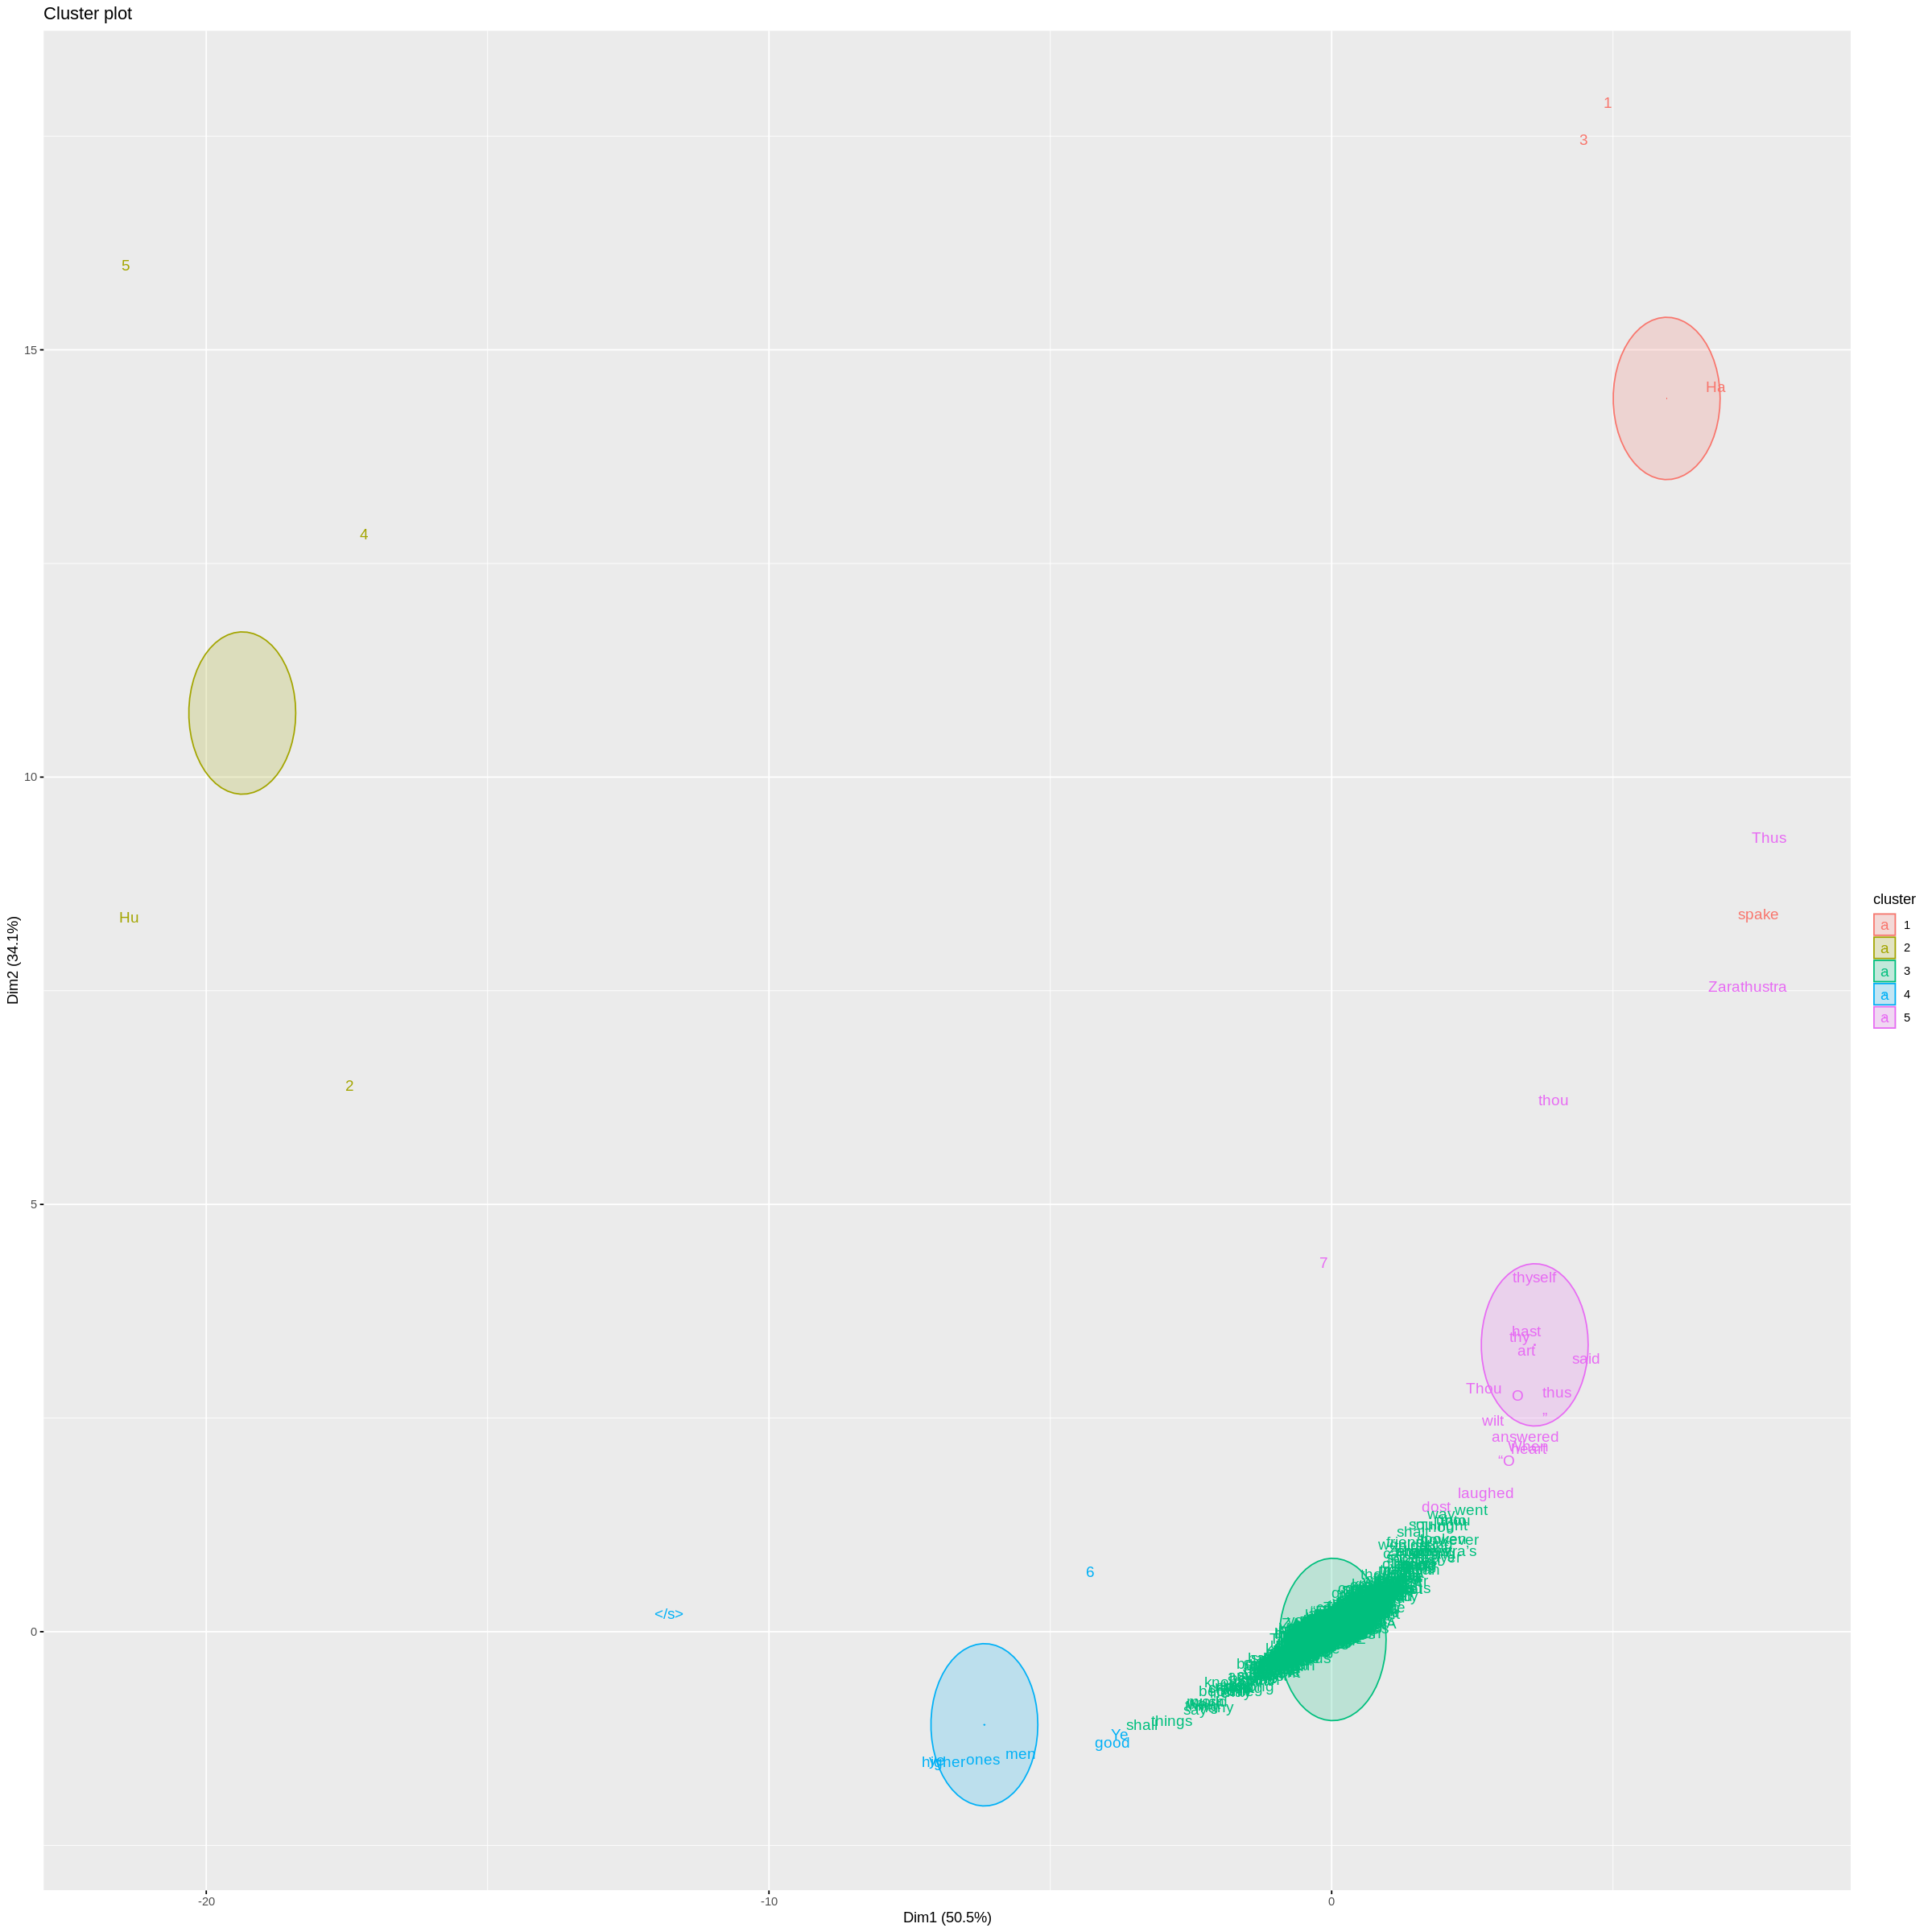

In [ ]:
library(NbClust)
library(factoextra)
nbc = kmeans(e3d, 5)
fviz_cluster(nbc, data = e3d, geom = c("text"), ellipse.type = "euclid")